In [1]:
import gwpy
from gwpy.timeseries import TimeSeries
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
class SensorData:
    
    default_start = gwpy.time.tconvert('May 12 2019 05:00:00 UTC').gpsSeconds
    default_end = default_start + 60*5
    
    def __init__(self,name,channel,startTime=default_start, endTime=default_end):
        self.name = name
        
        if path.exists('./data/{}_{}.hdf5'.format(self.name,startTime)):
            self.data = TimeSeries.read('./data/{}_{}.hdf5'.format(self.name,startTime))
        else:
            self.data = TimeSeries.fetch(channel,startTime,endTime)
            self.data.write('./data/{}_{}.hdf5'.format(self.name,startTime))
            
    def Coherence(self,b_channel,fftlength=10,overlap=7):
        self.b_channel = b_channel
        self.coh = self.data.coherence(b_channel,fftlength,overlap)
        
    def ASD(self,fftl=100,ovlp=75):
        self.sp = self.data.spectrogram2(fftlength=fftl,overlap=ovlp)**(1/2.)
        self.asd_sp = self.sp.percentile(50)[1:]
        if str(self.data.channel)[3:6]=='PEM':
            self.asd_sp = self.asd_sp * 6.1e-6/(4*np.pi**2*self.asd_sp.frequencies.value**2)
        elif str(self.data.channel)[3:6]=='ISI':
            self.asd_sp = self.asd_sp * 1e-9/(2*np.pi*self.asd_sp.frequencies.value)

In [3]:
names = ['itmx_gnd','itmx_acc',
         'itmy_gnd','itmy_acc',
         'etmx_gnd','etmx_acc',
         'etmy_gnd','etmy_acc']

channels = ['L1:ISI-GND_STS_ITMX_X_DQ','L1:PEM-CS_ACC_BEAMTUBE_150X_X_DQ',
            'L1:ISI-GND_STS_ITMY_Y_DQ','L1:PEM-CS_ACC_BEAMTUBE_150Y_Y_DQ',
            'L1:ISI-GND_STS_ETMX_X_DQ','L1:PEM-EX_ACC_BEAMTUBE_3950X_X_DQ',
            'L1:ISI-GND_STS_ETMY_Y_DQ','L1:PEM-EY_ACC_BEAMTUBE_3950Y_Y_DQ']

train_start = gwpy.time.tconvert('May 5 2019 20:30:00 UTC').gpsSeconds
train_end   = train_start + 60*5

quiet = {names[x]: SensorData(names[x],channels[x]) for x in xrange(len(names))}
train = {names[x]: SensorData(names[x],channels[x],startTime=train_start,
         endTime=train_end) for x in xrange(len(names))}

In [4]:
for x in names:
    quiet[x].ASD()
    train[x].ASD()

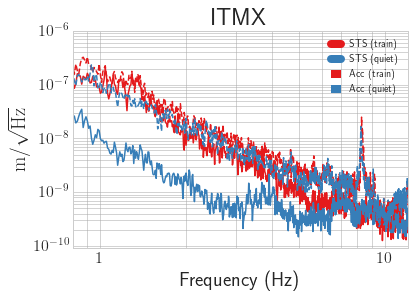

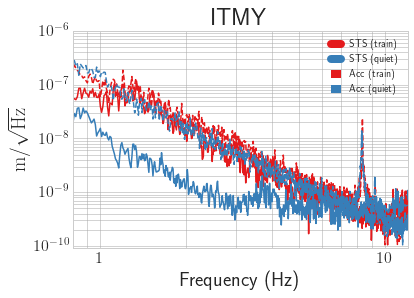

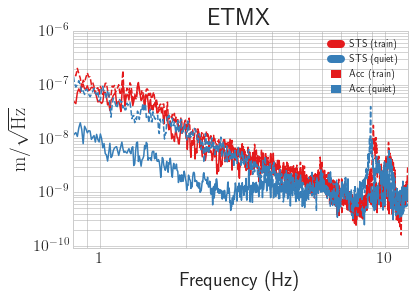

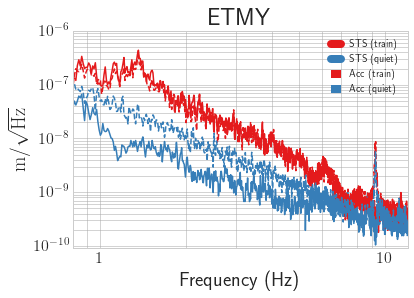

In [5]:
plt.style.use('seaborn-whitegrid')
freqs = [0.8,12]
limy  = [9e-11,1e-6]

for x in names[::2]:
    fig, ax = plt.subplots(1,1)#,figsize=[16,9])
    ax.set_prop_cycle('color',plt.cm.Set1(np.linspace(0,1,9)))
    ax.plot(train[x].asd_sp,label='STS (train)')
    ax.plot(quiet[x].asd_sp,label='STS (quiet)')
    ax.set_prop_cycle('color',plt.cm.Set1(np.linspace(0,1,9)))
    ax.plot(train[names[names.index(x)+1]].asd_sp,'--',label='Acc (train)')
    ax.plot(quiet[names[names.index(x)+1]].asd_sp,'--',label='Acc (quiet)')
    ax.set_xlim(freqs)
    ax.set_ylim(limy)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Frequency (Hz)',fontsize=20)
    ax.set_ylabel(r'$\rm m/\sqrt{\rm Hz}$',fontsize=20)
    ax.set_title('{}'.format(channels[names.index(x)][15:19]),fontsize=24)
    ax.legend()
    ax.grid(which='both',axis='both',color='darkgrey')
    #plt.savefig('./plots/{}_asd.png'.format(x))

In [ ]:
for x in names[::2]:
    quiet[x].Coherence(quiet[names[names.index(x)+1]].data)
    train[x].Coherence(train[names[names.index(x)+1]].data

In [ ]:
plt.style.use('seaborn-whitegrid')

for x in names[::2]:
    fig, ax = plt.subplots(1,1,figsize=[16,9])
    ax.set_prop_cycle('color',plt.cm.Set1(np.linspace(0,1,9)))
    ax.plot(train[x].coh,label='train')
    ax.plot(quiet[x].coh,label='quiet')
    ax.set_xlim([0.2,30])
    ax.set_xscale('log')
    ax.set_xlabel('Frequency (Hz)',fontsize=20)
    ax.set_ylabel('Coherence',fontsize=20)
    ax.set_title('{}/{}'.format(channels[names.index(x)][3:],channels[names.index(x)+1][3:]),fontsize=20)
    ax.legend()
    ax.grid(which='both',axis='both',color='darkgrey')
    #plt.savefig('./plots/{}_coh.png'.format(x))